<a href="https://colab.research.google.com/github/anagh07/stock_price_predictor/blob/colab/lstm_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install pyspark
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/stocks_kaggle_dataset1/

/content/drive/MyDrive/stocks_kaggle_dataset1


In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/stocks_kaggle_dataset1'

In [ ]:
# !kaggle datasets download -d qks1lver/nasdaq-and-nyse-stocks-histories 

In [ ]:
# !unzip nasdaq-and-nyse-stocks-histories.zip

In [12]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
%cd full_history/

In [ ]:
# filename = os.path.join('.', 'data', 'nasdaq_nyse', 'full_history', 'A.csv')
filename = '/content/drive/MyDrive/stocks_kaggle_dataset1/full_history/A.csv'
df = spark.read.csv(filename, header=True, mode="DROPMALFORMED")
df.show()


In [15]:
import pyspark.sql.functions as f
df = df.withColumn('date', f.to_date('Date'))

In [ ]:
df.show(n=5)

In [20]:
date_breakdown = ['year', 'month', 'day']
for i in enumerate(date_breakdown):
    index = i[0]
    name = i[1]
    df = df.withColumn(name, f.split('date', '-')[index])

df.show(n=10)

+----------+-------+------------------+------------------+------------------+------------------+------------------+----+-----+---+
|      date| volume|              open|             close|              high|               low|          adjclose|year|month|day|
+----------+-------+------------------+------------------+------------------+------------------+------------------+----+-----+---+
|2018-11-02|2272100| 65.80000305175781| 65.93000030517578| 66.61000061035156| 65.44000244140625| 65.93000030517578|2018|   11| 02|
|2018-11-01|1882400| 65.06999969482422| 65.22000122070312| 65.33999633789062| 64.58000183105469| 65.22000122070312|2018|   11| 01|
|2018-10-31|3820700|  64.3499984741211| 64.79000091552734|  65.9800033569336| 64.19000244140625| 64.79000091552734|2018|   10| 31|
|2018-10-30|3076700|62.349998474121094| 63.63999938964844|63.720001220703125| 61.68000030517578| 63.63999938964844|2018|   10| 30|
|2018-10-29|2919900|63.650001525878906| 62.08000183105469| 64.16999816894531|61.130

In [21]:
df_plot = df.select('year', 'adjclose').toPandas()

In [23]:
# from matplotlib import pyplot as plt
# %matplotlib inline
# df_plot.set_index('year', inplace=True)
# df_plot.plot(figsize=(16, 6), grid=True)
# plt.title('Agilent Technologies stock')
# plt.ylabel('Stock Quote ($)')
# plt.show()

In [24]:
df.toPandas().shape

(4771, 10)

In [25]:
df.dropna().count()

4771

In [27]:
df.select('Open', 'High', 'Low', 'Close', 'adjclose').describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|              Open|              High|               Low|             Close|          adjclose|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              4771|              4771|              4771|              4771|              4771|
|   mean|31.045006787294714|31.490768324876576|30.608470048526627| 31.05803767002196|28.987821238767022|
| stddev|15.308677145530849|15.537495715996506|15.077564265026519|15.303915818251506| 15.27122916378047|
|    min|              10.0|10.007153511047363|              10.0|              10.0| 10.00198745727539|
|    max| 95.13591003417969| 99.38304901123047| 93.70529174804688| 93.88411712646484| 99.14691162109375|
+-------+------------------+------------------+------------------+------------------+------------------+



In [ ]:
df.groupBy(['year']).agg({'adjclose':'count'})\
    .withColumnRenamed('count(adjclose)', 'Row Count')\
    .orderBy(["year"],ascending=False)\
    .show()

In [29]:
trainDF = df[df.year < 2017]
testDF = df[df.year > 2016]

In [30]:
trainDF.toPandas().shape

(4307, 10)

In [31]:
testDF.toPandas().shape

(464, 10)

In [33]:
# trainDF_plot = trainDF.select('year', 'adjclose').toPandas()
# trainDF_plot.set_index('year', inplace=True)
# trainDF_plot.plot(figsize=(16, 6), grid=True)
# plt.title('Apple Stock 2000-2016')
# plt.ylabel('Stock Quote ($)')
# plt.show()

In [ ]:
# testDF_plot = testDF.select('year', 'Adj Close').toPandas()
# testDF_plot.set_index('year', inplace=True)
# testDF_plot.plot(figsize=(16, 6), grid=True)
# plt.title('Apple Stock 2017-2018')
# plt.ylabel('Stock Quote ($)')
# plt.show()

In [34]:
import numpy as np
trainArray=np.array(trainDF.select('Open','High','Low','Close','Volume','adjclose').collect())
testArray=np.array(testDF.select('Open','High','Low','Close','Volume','adjclose').collect())

In [35]:
print(trainArray[0])
print('---------------')
print(testArray[0])

['45.7599983215332' '45.81999969482422' '45.380001068115234'
 '45.560001373291016' '1216100' '44.84896469116211']
---------------
['65.80000305175781' '66.61000061035156' '65.44000244140625'
 '65.93000030517578' '2272100' '65.93000030517578']


In [36]:
from sklearn.preprocessing import MinMaxScaler
minMaxScale = MinMaxScaler()

In [37]:
minMaxScale.fit(trainArray)

MinMaxScaler()

In [38]:
testingArray = minMaxScale.transform(testArray)
trainingArray = minMaxScale.transform(trainArray)

In [39]:
print(testingArray[0])
print('---------------')
print(trainingArray[0])

[0.5594522  0.54345317 0.60211989 0.5489041  0.02718118 0.64043656]
---------------
[0.36663784 0.35080771 0.39361519 0.35668501 0.01013746 0.41224046]


In [40]:
xtrain = trainingArray[:, 0:-1]
xtest = testingArray[:, 0:-1]
ytrain = trainingArray[:, -1:]
ytest = testingArray[:, -1:]

In [41]:
trainingArray[0]

array([0.36663784, 0.35080771, 0.39361519, 0.35668501, 0.01013746,
       0.41224046])

In [42]:
xtrain[0]

array([0.36663784, 0.35080771, 0.39361519, 0.35668501, 0.01013746])

In [43]:
ytrain[0]

array([0.41224046])

In [44]:
print('xtrain shape = {}'.format(xtrain.shape))
print('xtest shape = {}'.format(xtest.shape))
print('ytrain shape = {}'.format(ytrain.shape))
print('ytest shape = {}'.format(ytest.shape))

xtrain shape = (4307, 5)
xtest shape = (464, 5)
ytrain shape = (4307, 1)
ytest shape = (464, 1)


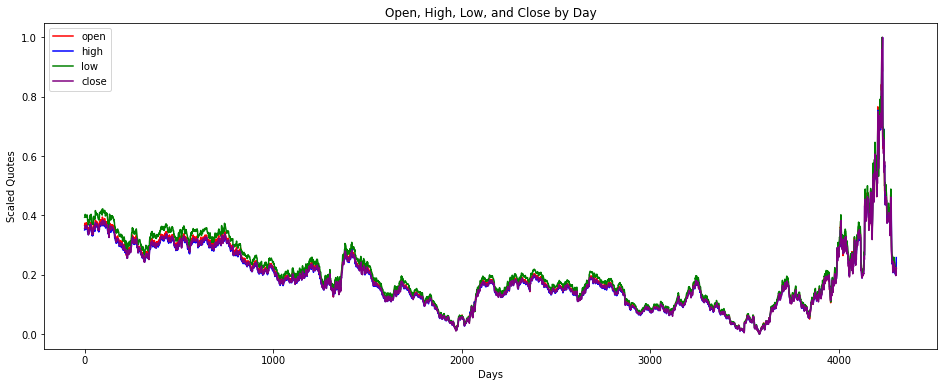

In [45]:
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,0],color='red', label='open')
plt.plot(xtrain[:,1],color='blue', label='high')
plt.plot(xtrain[:,2],color='green', label='low')
plt.plot(xtrain[:,3],color='purple', label='close')
plt.legend(loc = 'upper left')
plt.title('Open, High, Low, and Close by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

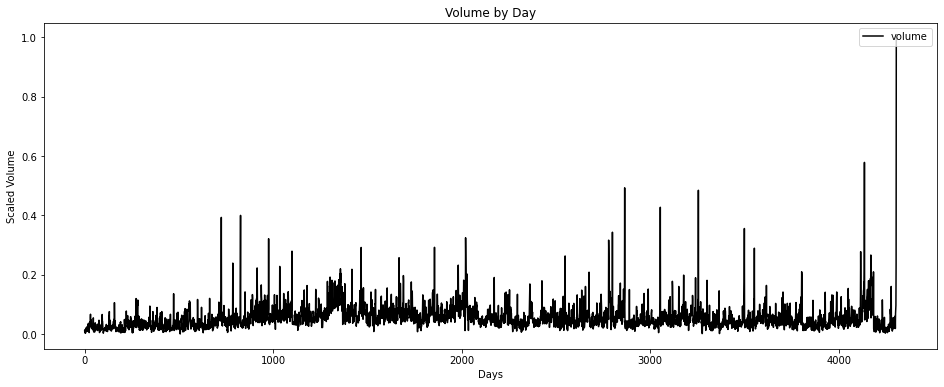

In [46]:
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,4],color='black', label='volume')
plt.legend(loc = 'upper right')
plt.title('Volume by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Volume')
plt.show()

In [47]:
from keras import models, layers

In [48]:
model = models.Sequential()
model.add(layers.LSTM(1, input_shape=(1,5)))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [49]:
xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

In [50]:
print('The shape of xtrain is {}: '.format(xtrain.shape))
print('The shape of xtest is {}: '.format(xtest.shape))

The shape of xtrain is (4307, 1, 5): 
The shape of xtest is (464, 1, 5): 


In [51]:
loss = model.fit(xtrain, ytrain, batch_size=10, epochs=100)

Epoch 1/100
431/431 [==============================] - 9s 5ms/step - loss: 0.0189
Epoch 2/100
431/431 [==============================] - 2s 5ms/step - loss: 0.0042
Epoch 3/100
431/431 [==============================] - 2s 5ms/step - loss: 5.5786e-04
Epoch 4/100
431/431 [==============================] - 2s 5ms/step - loss: 2.3300e-04
Epoch 5/100
431/431 [==============================] - 2s 5ms/step - loss: 1.9706e-04
Epoch 6/100
431/431 [==============================] - 2s 5ms/step - loss: 1.7866e-04
Epoch 7/100
431/431 [==============================] - 2s 5ms/step - loss: 1.6834e-04
Epoch 8/100
431/431 [==============================] - 2s 5ms/step - loss: 1.6274e-04
Epoch 9/100
431/431 [==============================] - 2s 5ms/step - loss: 1.6125e-04
Epoch 10/100
431/431 [==============================] - 2s 5ms/step - loss: 1.5861e-04
Epoch 11/100
431/431 [==============================] - 2s 5ms/step - loss: 1.5814e-04
Epoch 12/100
431/431 [==============================] - 2s 5

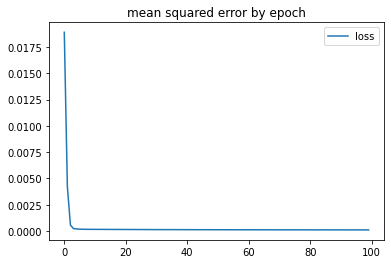

In [52]:
plt.plot(loss.history['loss'], label = 'loss')
plt.title('mean squared error by epoch')
plt.legend()
plt.show()

In [53]:
predicted = model.predict(xtest)

In [54]:
combined_array = np.concatenate((ytest, predicted), axis = 1)

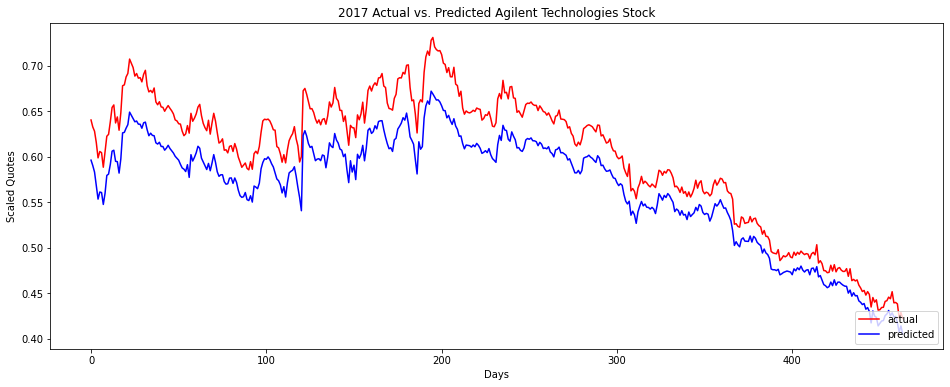

In [56]:
plt.figure(figsize=(16,6))
plt.plot(combined_array[:,0],color='red', label='actual')
plt.plot(combined_array[:,1],color='blue', label='predicted')
plt.legend(loc = 'lower right')
plt.title('2017 Actual vs. Predicted Agilent Technologies Stock')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()